# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.514323,False,-0.827101
1,1.335791,True,7.159879
2,0.815691,True,5.773155
3,-0.643784,False,1.899899
4,0.482402,False,0.087218
...,...,...,...
995,0.412267,False,-0.313098
996,0.174244,True,5.912689
997,0.574027,False,1.657991
998,-0.717837,False,-1.115055


<AxesSubplot: xlabel='v0'>

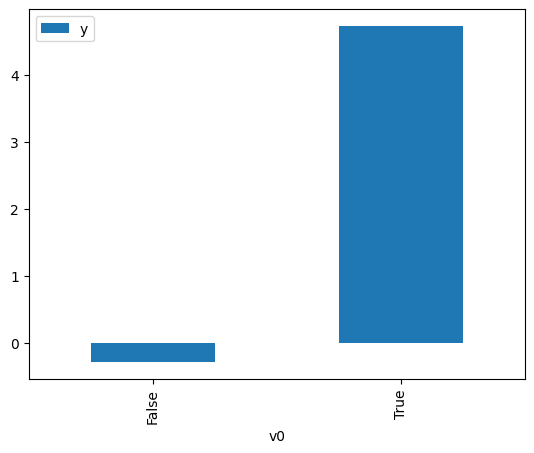

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

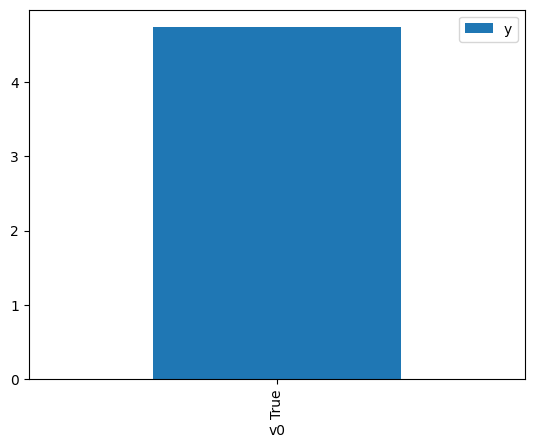

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.514323,False,-0.827101,0.594117,1.683171
1,-1.491861,False,-0.607017,0.751162,1.331271
2,0.165015,False,2.148263,0.469538,2.129755
3,-2.196448,False,-1.307902,0.835693,1.196612
4,-1.981386,False,-2.187982,0.812644,1.230551
...,...,...,...,...,...
995,-1.464118,False,-1.104269,0.747303,1.338146
996,-2.530016,False,-4.591898,0.866864,1.153583
997,0.523404,False,0.583821,0.404351,2.473096
998,-2.556500,False,-4.129267,0.869111,1.150601


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.246503,True,5.522314,0.454450,2.200460
1,-0.420720,True,4.408742,0.422699,2.365747
2,0.095401,True,5.531009,0.517607,1.931969
3,1.128013,True,7.457028,0.697420,1.433855
4,0.992516,True,5.757657,0.675839,1.479642
...,...,...,...,...,...
995,-1.101255,True,2.349495,0.306699,3.260528
996,0.232086,True,5.184403,0.542811,1.842263
997,0.623530,True,6.448518,0.613371,1.630335
998,-0.022469,True,6.148919,0.495795,2.016963


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              7302.
Date:                Wed, 09 Nov 2022   Prob (F-statistic):                        0.00
Time:                        11:49:10   Log-Likelihood:                         -1435.4
No. Observations:                1000   AIC:                                      2875.
Df Residuals:                     998   BIC:                                      2885.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3675      0.032     42.725      0.000       1.305       1.430
x2             5.1047      0.047    107.919      0.000       5.012       5.197
==============================================================================
Omnibus:                        3.609   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                3.485
Skew:                          -0.120   Prob(JB):                        0.175
Kurtosis:                       3.160   Cond. No.                         1.50
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""